In [31]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/shwetank/code/makemore-utils-nbs')
from utils import create_dataset, CharDataset, evaluate_loss, print_samples, get_lr_loss
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random
from sklearn.manifold import TSNE
from models import MLP
import numpy as np
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# Set up MPS if available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")


In [33]:
# Read file and create training and test sets
names, vocab, max_length = create_dataset('../names.txt')
# print(len(names), vocab, max_length)
seed_value = 42
random.seed(seed_value)
n1 = int(0.9*len(names))
random.shuffle(names)
# print(names[0:5], names_ss[0:5]) # check that dataset is shuffled
train_data = CharDataset(names[:n1], vocab=vocab, max_length=max_length)
test_data = CharDataset(names[n1:], vocab=vocab, max_length=max_length)


In [34]:
# ## Hyperparameters
vocab_size = len(vocab) + 1 # +1 for special characters
embedding_dimension = 10
hidden_dimension = 200
block_length = max_length + 1 

# class MLP(nn.Module):
#     def __init__(self,vocab_size):
#         super(MLP, self).__init__()
#         self.wte = nn.Embedding(vocab_size + 1, embedding_dimension)
#         self.mlp = nn.Sequential(
#             nn.Linear(embedding_dimension*block_length, hidden_dimension),
#             # nn.BatchNorm1d(hidden_dimension),
#             nn.Tanh(),
#             nn.Linear(hidden_dimension, vocab_size + 1)
#         )

#     # Rewrite forward pass to make it more intuitive - this is clever but not intuitive
#     def forward(self, x, targets = None):
#         # input to the neural network is x of dimension batch_size, time_index
#         embs = []
#         for k in range(block_length):
#             tok_emb = self.wte(x) # batch_size, time_index, embedding_dimension
#             # this rotates the matrix to make last element of the column the first
#             x = torch.roll(x, 1, 1)
#             # this sets the first column to a special <BLANK> token making the entire operation causal again. You update this to <BLANK> as many times as you rotate there by keeing things causal 
#             x[:, 0] = vocab_size 
#             embs.append(tok_emb)

#         # print(x)
#         x = torch.cat(embs, -1) # batch_size, time_index, embedding_dimension x block_length
#         logits = self.mlp(x)    # batch_size, time_index, vocab_size + 1. 

#         # We need to align targets and logits to calculate cross entropy. targets.view(-1) --> 1D vector batch_size x time_index.
#         # logits.shape[-1] --> vocab_size + 1 --> pops out as the last dimension. First 2D are batch_size x time_index
#         loss = None
#         if targets is not None:
#             loss = F.cross_entropy(logits.view(-1,logits.shape[-1]), targets.view(-1), ignore_index=-1)

#         return logits, loss

In [35]:
# class MLP(nn.Module):
#     """
#     takes the previous block_size tokens, encodes them with a lookup table,
#     concatenates the vectors and predicts the next token with an MLP.

#     Reference:
#     Bengio et al. 2003 https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
#     """

#     def __init__(self, config):
#         super().__init__()
#         self.block_size = max_length + 1
#         self.vocab_size = vocab_size
#         self.wte = nn.Embedding(vocab_size + 1,  embedding_dimension) # token embeddings table
#         # +1 in the line above for a special <BLANK> token that gets inserted if encoding a token
#         # before the beginning of the input sequence
#         self.mlp = nn.Sequential(
#             nn.Linear(self.block_size * embedding_dimension, hidden_dimension),
#             nn.Tanh(),
#             nn.Linear(hidden_dimension, self.vocab_size)
#         )

#     def get_block_size(self):
#         return self.block_size

#     def forward(self, idx, targets=None):

#         # print('idx0:', idx)
#         # print('targets:', targets)
#         # gather the word embeddings of the previous 3 words - No actually this uses entire sequence
#         embs = []
#         for k in range(self.block_size):
#             tok_emb = self.wte(idx) # token embeddings of shape (b, t, n_embd)
#             idx = torch.roll(idx, 1, 1)
#             idx[:, 0] = self.vocab_size # special <BLANK> token
#             embs.append(tok_emb)
#             # print(f'idx{k}:', idx)

#         # print('block_size:', self.block_size)
#         # print('k:', k)
#         # print('idx:', idx)
#         # print(embs)
#         # sys.exit(1)

#         # concat all of the embeddings together and pass through an MLP
#         x = torch.cat(embs, -1) # x is (b, t, n_embd * block_size) 
#         logits = self.mlp(x) # logits are (b, t, vocab_size)
#         # print('logits shape:', logits.shape)

#         # if we are given some desired targets also calculate the loss
#         loss = None
#         if targets is not None:
#             loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

#         return logits, loss


In [37]:
## Get a small batch to make sure model is working as expected (loss of ~3.4 is consistent with what you would expect ballpark -log(1/27.) ~ 3.3 )
batch_size = 1
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)
yb = yb.to(device)
# print(xb)
# print(yb)

# Init the model
model = MLP(max_length, vocab_size, embedding_dimension, hidden_dimension).to(device)
logits, loss = model(xb,yb)
# print(loss)
# print('xb:', xb)
# print(xb.shape)
# print('tok_emb:', tok_emb)
# print('tok_emb shape:', tok_emb.shape)
# print('embs:', embs)
# print('embs shape:', embs.shape)
# print(logits)
# print(logits.shape)
# print(loss)
# print(loss.shape)

In [39]:
# Set up optimizer and model
batch_size = 512
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
model = MLP(max_length, vocab_size, embedding_dimension, hidden_dimension).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

In [40]:
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)
yb = yb.to(device)
logits, loss = model(xb,yb)
print(loss)

tensor(3.2855, device='mps:0', grad_fn=<NllLossBackward0>)


In [41]:
# ## Optimal lr sweep
# import matplotlib.pyplot as plt
# lri, lossi =  get_lr_loss(model, optimizer, train_dataloader, batch_size, 500, -2, -1.5)
# plt.plot(lri, lossi)
# # Add labels to the x-axis and y-axis
# plt.xlabel('LR (Learning Rate)')
# plt.ylabel('Loss')

In [42]:
# Training loop - Initialized in separate loop so that it can be re run without reinitialization that will wipe things out
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

tr_loss = []
te_loss = []

In [43]:
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 1000
for steps in range(n_epochs):
    xb, yb = next(iter(train_dataloader))
    xb = xb.to(device)
    yb = yb.to(device)
    logits, loss = model(xb,yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ltr, lte = evaluate_loss(model, train_dataloader, test_dataloader, device, num_batches=10)
    tr_loss.append(ltr)
    te_loss.append(lte)
    # print(loss.item())

    # if steps % 99 == 0:
    #     print('ltr: ', ltr, 'lte: ', lte, 'single shot loss:', loss.item())

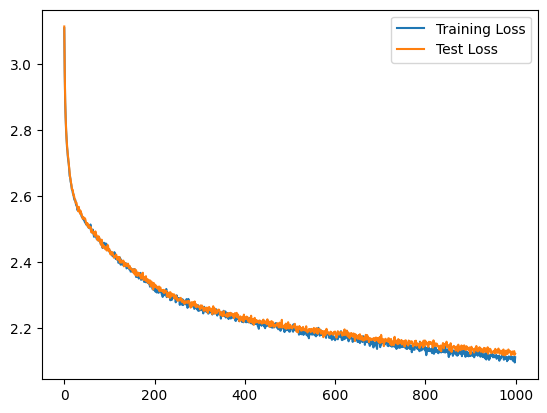

training loss:  2.1161
validation loss:  2.1312


In [44]:
## Plot loss 
import matplotlib.pyplot as plt

plt.plot(tr_loss, label='Training Loss')  # Plot training loss
plt.plot(te_loss, label='Test Loss') 

plt.legend()
plt.show()

print('training loss: ', round(torch.mean(torch.tensor(tr_loss[-100:])).item(),4)), 
print('validation loss: ', round((torch.mean(torch.tensor(te_loss[-100:]))).item(),4))

In [45]:
## Pretty print the samples
print_samples(model, train_data, max_length, device, num=32)

yarella
ishyam
el
aliu
hani
lamiah
dyuk
navellis
liliyah
aleyi
gejaina
canre
gaciis
abri
ezaiah
lai
kamariani
savani
naviya
stimon
sanielin
aadon
karri
ka
naana
avaabah
trensa
hablee
kaileigh
brie
pashira
zalviana


['stop', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'blank']


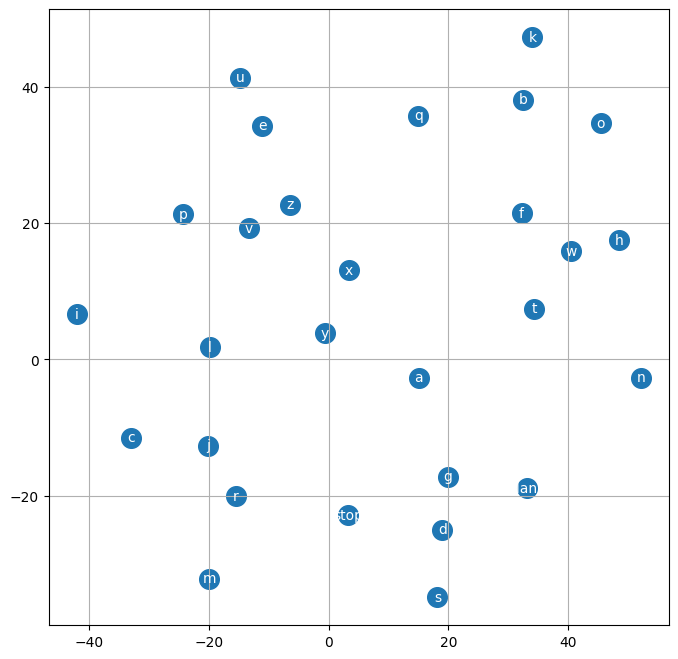

In [46]:
## Plot tsne or pca for embeddings
# t-SNE example:
embeddings_matrix = model.wte.weight.data.cpu().numpy()
tsne = TSNE(n_components=2, perplexity=5)
reduced_embeddings = tsne.fit_transform(embeddings_matrix)

# Create vectors for ticklabels
ticklabels = list(train_data.itos.values())
ticklabels.insert(0,'stop')
ticklabels.insert(27,'blank')
x_ticklabel_vec = np.arange(len(ticklabels))
y_ticklabel_vec = np.arange(len(ticklabels))
print(ticklabels)

# visualize dimensions 0 and 1 of the embedding matrix for all characters
plt.figure(figsize=(8,8))
plt.scatter(reduced_embeddings[:,0].data, reduced_embeddings[:,1].data, s=200)
for i in range(embeddings_matrix.shape[0]):
    plt.text(reduced_embeddings[i,0].item(), reduced_embeddings[i,1].item(), ticklabels[i], ha="center", va="center", color='white')
plt.grid('minor')

## Observations
### Subjective appraisal
1. Better names
### TSNE
1. Vowels get separated and for max_length we see a lot more structure 
2. 'Stop' and 'Blank' clustered with consonants
3. Loss is dependent on block length - In 5000 epochs of training we get average loss for last 100 losses - for block_length 3 we get to te ~ 2.3, with 8 we get to te ~2.5 for max_length we get 2.5. This could just mean that we need to train for a lot longer with bigger block_length
4. After training longer context model its clear that it bottoms out on loss at ~2.4 but tsne plot gets a lot clearer structure. 
5. Further training with a smalller learning rate reduces loss to ~ 2.3